# Monte Carlo Option Pricer

## 1. Overview

Monte Carlo simulations provide a methodology for addressing probabilistic challenges
through the artificial numerical creation of numerous potential scenarios. This approach enables
the computation of statistical characteristics of the results, including expected values and the
variance of probabilities associated with specific outcomes. Applied to financial options which is
notoriously difficult to price (as their underlying assets has a large dimensionality and the
performance of other numerical methods typically suffer from the “curse of dimensionality”)
Monte Carlo simulation steps in as a valuable tool for pricing intricate derivatives when
analytical formulas are not feasible and we have to result to data generation. Finally this will
culminate in an option pricing model that uses the randomly generated paths to calculate the
associated payoff of the option for each path.

In [92]:
# Import dependencies
import math
import datetime
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

## 2. Obtaining Data

In [93]:
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix

stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']
stocks = [stock + '.AX' for stock in stockList]
endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=300)
meanReturns, covMatrix = get_data(stocks, startDate, endDate)


[*********************100%%**********************]  6 of 6 completed


## 3. Portfolio Simulation
First step to the project is to create the underlying of a Monte Carlo simulator, the basis
of which is that the probability of varying outcomes cannot be determined because of random
variable interference. Therefore, a Monte Carlo simulation focuses on constantly repeating
random samples to achieve certain results. In this project, I will aim to generate 1,000 iterations
each of 20 steps (approximately a month's worth of pricing data) for a total of 20,000 data points.

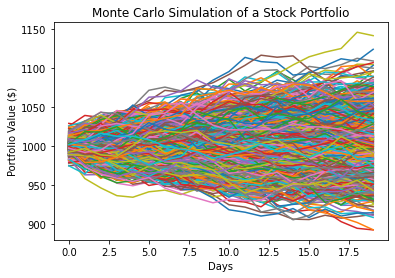

VaR_5: $56
CVaR_5: $69


In [138]:
# Set seed for reproducibility
np.random.seed(42)

# Generate random weights and normalize them
weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

# Monte Carlo Method
mc_sims = 1000  # number of simulations
T = 20  # timeframe in days

# Create a matrix of mean returns for each stock over the simulation period
meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

# Initialize an array to store simulated portfolio values
portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 1000

for m in range(mc_sims):
    # Generate uncorrelated random variables
    Z = np.random.normal(size=(T, len(weights)))
    # Cholesky decomposition to create a lower triangular matrix
    L = np.linalg.cholesky(covMatrix)
    # Generate correlated daily returns for individual stocks
    dailyReturns = meanM + np.inner(L, Z)
    # Calculate portfolio value for each simulation
    portfolio_sims[:, m] = np.cumprod(np.inner(weights, dailyReturns.T) + 1) * initialPortfolio

# Plot the simulated portfolio values
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('Monte Carlo Simulation of a Stock Portfolio')
plt.show()

def mcVaR(returns, alpha=5):
    """ Calculate Value at Risk (VaR) for a given confidence level alpha """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    """ Calculate Conditional Value at Risk (CVaR) for a given confidence level alpha """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")

# Extract final portfolio values for analysis
portResults = pd.Series(portfolio_sims[-1, :])

# Calculate VaR and CVaR
VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

# Print results
print('VaR_5: ${}'.format(round(VaR)))
print('CVaR_5: ${}'.format(round(CVaR)))


This approach of generating option data can be expressed with one source of uncertainty
which is the price of the underlying stock in question. The price of the underlying instrument, St,
is usually modeled such that it follows a geometric Brownian motion with constant drift μ and
volatility σ. The resulting equation can be written as
$$dS_t = μS_td_t + σS_tdW_t$$

where dWt is randomly sampled from a normal distribution.

## 4. Evaluation vs Real World and Black-Scholes

The way we can evaluate this model is by comparison to actual option price (which for European options are priced via Black–Scholes model). Since the
underlying random process is the same, for enough price paths, the value of a european option
here should be the same as under Black–Scholes. More generally though, this simulation can be
employed for other path dependent exotic derivatives which we can pursue as stretch goals.

In [95]:
# initial derivative parameters
S = 101.15          #stock price
K = 98.01           #strike price
vol = 0.0991        #volatility (%)
r = 0.01            #risk-free rate (%)
N = 20              #number of time steps
M = 1000            #number of simulations

market_value = 3.86 #market price of option
T = ((datetime.date(2022,3,17)-datetime.date(2022,1,17)).days+1)/365    #time in years

In [128]:
# Precompute constants
def mc(S, K, T, N, M, r, vol):
    dt = T / N
    nudt = (r - 0.5 * vol**2) * dt
    volsdt = vol * np.sqrt(dt)
    lnS = np.log(S)

    # Monte Carlo Method
    Z = np.random.normal(size=(N, M))
    delta_lnSt = nudt + volsdt * Z
    lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
    lnSt = np.concatenate((np.full(shape=(1, M), fill_value=lnS), lnSt))

    # Compute Expectation 
    ST = np.exp(lnSt)
    # payoff
    CT = np.maximum(0, ST - K)
    C0w = np.exp(-r * T) * np.sum(CT[-1]) / M
    # Standard Error
    sigma = np.sqrt(np.sum((CT[-1] - C0w)**2) / (M - 1))
    SEw = sigma / np.sqrt(M)
    return np.round(C0w, 2), sigma/11
    print("Call value is ${0} with SE +/- {1}".format(np.round(C0w, 2), np.round(SEw, 2)))

In [129]:
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import delta, gamma, vega, theta, rho
# Define variables 
def blackScholesCompare(S, K, T, N, M, r, vol):
    "Calculate BS price of call"
    price, sigma = mc(S, K, T, N, M, r, vol)
    return price, bs("p", S, K, T, r, sigma)

In [130]:
print("Option Price: ", blackScholesCompare(S, K, T, N, M, r, vol))

Option Price:  (3.67, 3.6579238616767)


# Antithetic Variates

In [135]:
#precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

# Monte Carlo Method
Z = np.random.normal(size=(N, M))
delta_lnSt1 = nudt + volsdt*Z
delta_lnSt2 = nudt - volsdt*Z
lnSt1 = lnS + np.cumsum(delta_lnSt1, axis=0)
lnSt2 = lnS + np.cumsum(delta_lnSt2, axis=0)

# Compute Expectation and SE
ST1 = np.exp(lnSt1)
ST2 = np.exp(lnSt2)
CT = 0.5 * ( np.maximum(0, ST1[-1] - K) + np.maximum(0, ST2[-1] - K) )
C0 = np.exp(-r*T)*np.sum(CT)/M

sigma = np.sqrt( np.sum( (CT - C0)**2) / (M-1) )
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))


Call value is $3.78 with SE +/- 0.03


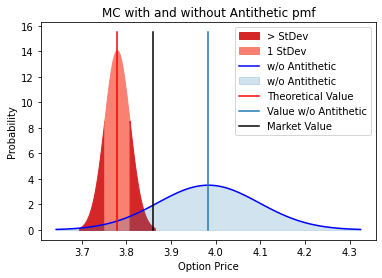

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Generate x values
x1 = np.linspace(C0 - 3 * SE, C0 - 1 * SE, 100)
x2 = np.linspace(C0 - 1 * SE, C0 + 1 * SE, 100)
x3 = np.linspace(C0 + 1 * SE, C0 + 3 * SE, 100)
xw = np.linspace(C0w - 3 * SEw, C0w + 3 * SEw, 100)

# Calculate normal distributions
s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)
sw = stats.norm.pdf(xw, C0w, SEw)

# Plotting
plt.fill_between(x1, s1, color='tab:red', label='> StDev')
plt.fill_between(x2, s2, color='salmon', label='1 StDev')
plt.fill_between(x3, s3, color='tab:red')
plt.plot(xw, sw, 'b-', label='w/o Antithetic')
plt.fill_between(xw, sw, alpha=0.2, color='tab:blue', label='w/o Antithetic')

plt.plot([C0, C0], [0, max(s2) * 1.1], 'r', label='Theoretical Value')
plt.plot([C0w, C0w], [0, max(s2) * 1.1], color='tab:blue', label='Value w/o Antithetic')
plt.plot([market_value, market_value], [0, max(s2) * 1.1], 'k', label='Market Value')

plt.title('MC with and without Antithetic pmf')

plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()
